<a href="https://colab.research.google.com/github/GarganoNicolas/timeSeries1_codificandobits/blob/main/timeSeries1_codificandobits_lstm_timeseries_univariado_unistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.codificandobits.com/blog/series-de-tiempo-redes-lstm-prediccion-univariada-unistep/

https://www.youtube.com/watch?v=GtefKR-1MJc


#*FORECASTING* CON REDES LSTM - PARTE 2: MODELO UNIVARIADO - UNISTEP

## Contenido

1. [Introducción](#scrollTo=wHQ1yXwrk6CN)
2. [El set de datos](#scrollTo=QDm0J6L-7rGI&line=1&uniqifier=1)
3. [El problema a resolver](#scrollTo=CBJV_YRvj5CZ&line=1&uniqifier=1)
4. [Lectura del set de datos](#scrollTo=Es6L4nEckb3S&line=1&uniqifier=1)
5. [Pre-procesamiento](#scrollTo=vd5lyqNrlfFg)
6. [Creación y entrenamiento del modelo](#scrollTo=016D9eVw3Beb)
7. [Desempeño del modelo](#scrollTo=ZkI9vr5S69i_)
8. [Predicciones con el modelo entrenado](#scrollTo=fvqk4f8L3aXE&line=1&uniqifier=1)
9. [Conclusiones y sugerencias](#scrollTo=0AFY2trj_KLo&line=1&uniqifier=1)

## 1. Introducción

En el video anterior vimos las fases involucradas en el análisis exploratorio y la preparación del set de datos requeridas en la implementación de los modelos LSTM para pronosticar el comportamiento de la serie de tiempo.

En este video veremos el primer tipo de Red LSTM más sencillo para realizar la predicción: el modelo univariado - unistep.

La idea es predecir el comportamiento de la temperatura una hora a futuro (de ahí el término unistep) usando como entrada al modelo sólo el registro histórico de la temperatura (de ahí el término univariado).

##2. El set de datos

Recordemos que estamos usando el  [weather dataset](https://www.bgc-jena.mpg.de/wetter/weather_data.html), un set de datos que contiene el registro histórico de 14 diferentes variables climáticas en el período entre 2009 y 2015.

En el video anterior realizamos el análisis exploratorio del dataset y realizamos este pre-procesamiento:

1. Hicimos el manejo de datos faltantes
2. Verificamos que el dataset no tuviese valores extremos
3. Re-interpolamos el dataset para garantizar una periodicidad de 1 hora

##3. El problema a resolver

Crear y entrenar una Red LSTM usando el enfoque univariado + single-step:

![](https://drive.google.com/uc?export=view&id=14gH53G5kjyUCzzveosDD3mtJ5LQ8uLVx)


##4. Lectura del set de datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer set de datos
ruta = 'https://raw.githubusercontent.com/GarganoNicolas/timeSeries1_codificandobits/main/weather_dataset_preprocesado.csv'
df = pd.read_csv(ruta)
df

,datetime,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,2014-09-24 12:00:00,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1
50220,2014-09-24 13:00:00,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0
50221,2014-09-24 14:00:00,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5
50222,2014-09-24 15:00:00,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,2.86,4.32,172.0


Originalmente el dataset contiene 50.278 registros y 15 variables.

##5. Pre-procesamiento

Implica:

1. Partición en train/val/test (80%, 10%, 10%)
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento

Veamos cada una de estas fases.

### 5.1. Partición del set en entrenamiento, validación y prueba

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos además que:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

In [ ]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df['T (degC)'])

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (40179,)
Tamaño set de validación: (5022,)
Tamaño set de prueba: (5023,)


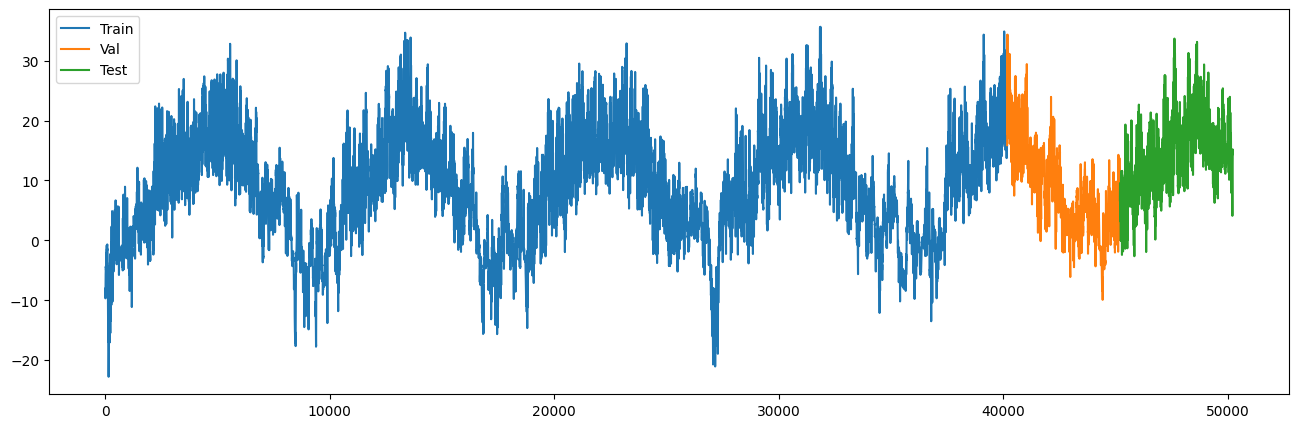

In [ ]:
# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
plt.legend();

Observemos que por ser un modelo univariado sólo estamos preservando la variable temperatura (y que incluso hemos eliminado la información de fecha y hora de cada registro).

###5.2 Generación del dataset supervisado (entrada y salida del modelo)

Debemos ajustar nuestro set de datos de acuerdo a lo especificado en la [documentación de las Redes LSTM en TensorFlow/Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):

![](https://drive.google.com/uc?export=view&id=14Sb7zIdjurirW-C6-DWDTvpxOVafTnTK)

Así que en este caso cada dato de entrenamiento será:

- Un arreglo de 24 (horas) x 1 (feature) correspondiente a la entrada
- Un arreglo de 1 (hora) x 1 (feature) correspondiente a la hora 25 (a predecir):

![](https://drive.google.com/uc?export=view&id=1uJeqYz9Hm2Q3LmEpXhZHogOI_rhj7YC2)

Crearemos una función que podremos reutilizar más adelante para implementar modelos más complejos:

In [ ]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (40154, 24, 1), y_tr: (40154, 1, 1)
Set de validación - x_vl: (4997, 24, 1), y_vl: (4997, 1, 1)
Set de prueba - x_ts: (4998, 24, 1), y_ts: (4998, 1, 1)


###5.3 Escalamiento

Es requerido para garantizar que todas las características se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]


    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
    # (en este caso 24x13)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: -22.76/-9.92/-2.64
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-0.5603492552645094/-0.31107687039890414

Min y_tr/y_vl/y_ts sin escalamiento: -22.76/-9.92/-2.64
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.5603492552645094/-0.31107687039890414

Max x_tr/x_vl/x_ts sin escalamiento: 35.65/34.34/33.68
Max x_tr/x_vl/x_ts con escalamiento: 1.0000000000000002/0.9551446670090742/0.932545796952577

Max y_tr/y_vl/y_ts sin escalamiento: 35.65/31.33/33.68
Max y_tr/y_vl/y_ts con escalamiento: 1.0000000000000002/0.8520801232665642/0.932545796952577


##6. Creación y entrenamiento del modelo

- Entradas: arreglos *x* (batches x input-length  x features = batches x 24 x 1)
- Salidas: arreglos *y* (batches x output-length x features = batches x 1 x 1)

Usaremos la raíz cuadrada del error cuadrático medio (o RMSE por sus siglas en Inglés: *root mean square error*) como pérdida para entrenar el modelo:

$RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

donde:
- $y$: temperatura real
- $\hat{y}$: temperatura predicha
- $N$: cantidad de predicciones

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 1 (feature)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
157/157 - 9s - loss: 0.1720 - val_loss: 0.0963 - 9s/epoch - 57ms/step
Epoch 2/80
157/157 - 1s - loss: 0.1134 - val_loss: 0.0872 - 682ms/epoch - 4ms/step
Epoch 3/80
157/157 - 1s - loss: 0.1025 - val_loss: 0.0789 - 648ms/epoch - 4ms/step
Epoch 4/80
157/157 - 1s - loss: 0.0902 - val_loss: 0.0698 - 625ms/epoch - 4ms/step
Epoch 5/80
157/157 - 1s - loss: 0.0746 - val_loss: 0.0594 - 644ms/epoch - 4ms/step
Epoch 6/80
157/157 - 1s - loss: 0.0618 - val_loss: 0.0536 - 649ms/epoch - 4ms/step
Epoch 7/80
157/157 - 1s - loss: 0.0574 - val_loss: 0.0517 - 652ms/epoch - 4ms/step
Epoch 8/80
157/157 - 1s - loss: 0.0548 - val_loss: 0.0494 - 648ms/epoch - 4ms/step
Epoch 9/80
157/157 - 1s - loss: 0.0524 - val_loss: 0.0476 - 681ms/epoch - 4ms/step
Epoch 10/80
157/157 - 1s - loss: 0.0504 - val_loss: 0.0456 - 647ms/epoch - 4ms/step
Epoch 11/80
157/157 - 1s - loss: 0.0484 - val_loss: 0.0440 - 658ms/epoch - 4ms/step
Epoch 12/80
157/157 - 1s - loss: 0.0468 - val_loss: 0.0424 - 664ms/epoch - 4ms/step
Epo

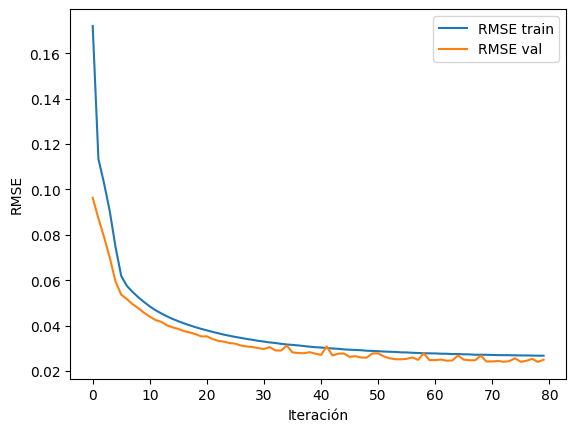

In [ ]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

**Observaciones y sugerencias:**

- El modelo no tiene *overfitting*
- Se sugiere afinar el modelo modificando varios de sus hiperparámetros y usando técnicas como, por ejemplo, *random grid search*. Los hiperparámetros a afinar pueden ser:
  - *INPUT_LENGTH* (esto implica modificar la fase de pre-procesamiento)
  - Número de unidades de la Red LSTM
  - Pérdida
  - Tasa de aprendizaje
  - Epochs
  - Batch size


## 7. Desempeño del modelo

Suponiendo que el modelo ya ha sido afinado y entrenado, verificaremos su desempeño para el set de prueba y lo compararemos con el desempeño obtenido con los sets de entrenamiento y validación.

Este desempeño es simplemente el RMSE obtenido con cada subset:

In [ ]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.025
  RMSE val:	 0.024
  RMSE test:	 0.029


Los desempeños son comparables lo cual quiere decir que el modelo generaliza bastante bien.

##8. Predicciones con el modelo entrenado

Suponiendo que el modelo ya ha sido afinado, podemos ponerlo a prueba con el set *test*.

Creemos primero una función para generar las predicciones:

In [ ]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [ ]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

Analicemos este desempeño gráficamente mostrando las temperaturas originales y las predichas por el modelo para cada uno de los 4.998 datos en el set de prueba:

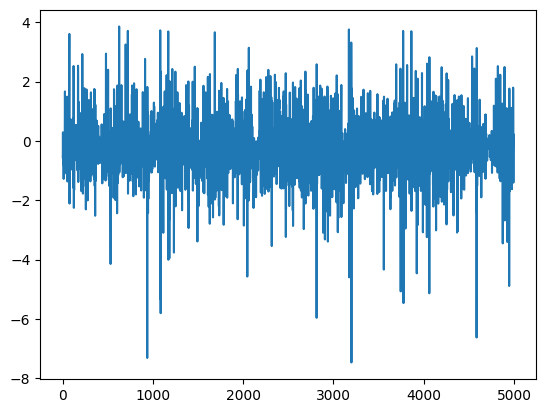

In [ ]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

Se observa que:

- El promedio de errores es cercano a cero
- Pero en algunos instantes de tiempo se alcanzan errores extremos de hasta -6 y +4 grados.

Estos errores se podrían reducir al hacer una afinación del modelo o modificando el enfoque de predicción.

## 9. Conclusiones y sugerencias

- Hemos entrenado un primer modelo univariado + uni-step
- Hemos visto los elementos a tener en cuenta para el pre-procesamiento de los datos
- Hemos visto el desempeño del modelo usando los datos de prueba y lo hemos comparado con lo obtenido para los sets de entrenamiento y validación
- En promedio el modelo tiene un desempeño adecuado (RMSEs relativamente bajos), aunque esto podría mejorar si se afinan sus hiperparámetros.

En el próximo video de la serie tomaremos como base el código implementado en este tutorial para implementar el segundo enfoque predictivo. Así que implementaremos una Red LSTM para realizar pronósticos del tipo univariado + multi-step.